In [19]:
from folps import * 
from cosmo_class import *

In [20]:
%%time
#linear power spectrum
classy  = run_class(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.0006442, 
                    As = 2e-9, ns = 0.965, z = 0.3, z_scale=[0.97],
                    N_ur = 2.0328,
                    khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')
kwargs = {'z': 0.3}

CPU times: user 2.26 s, sys: 12.1 ms, total: 2.28 s
Wall time: 318 ms


In [21]:
matrix = MatrixCalculator()
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_AfullTrue.npy


In [24]:
%%time
#1-loop
nonlinear = NonLinearPowerSpectrumCalculator(k=classy['k'], pklin=classy['pk'],
                                             mmatrices=mmatrices,
                                             kernels='eds',
                                             cosmo=classy['cosmo'],
                                             **kwargs)
table, table_now = nonlinear.calculate_loop_table()

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 68.7 ms


In [25]:
# Bias parameters
b1 = 1.645
b2 = -0.46
bs2 = -4./7*(b1 - 1)
b3nl = 32./315*(b1 - 1)
# EFT parameters
alpha0 = 3                 #units: [Mpc/h]^2
alpha2 = -28.9             #units: [Mpc/h]^2
alpha4 = 0.0               #units: [Mpc/h]^2
ctilde = 0.0               #units: [Mpc/h]^4
# Stochatic parameters
PshotP = 1. / 0.0002118763
alphashot0 = 0.08
alphashot2 = -8.1          #units: [Mpc/h]^2
pars = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]
qpar, qper = 1., 1.


k = np.logspace(np.log10(0.01), np.log10(0.3), num=100) # array of  output k in [h/Mpc]

In [26]:
%%time
multipoles = RSDMultipolesPowerSpectrumCalculator(kobs=k, qpar=qpar, qper=qper, pars=pars,
                                                  table=table, table_now=table_now)
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars, table=table, table_now=table_now)

CPU times: user 4.21 ms, sys: 4 µs, total: 4.22 ms
Wall time: 3.84 ms


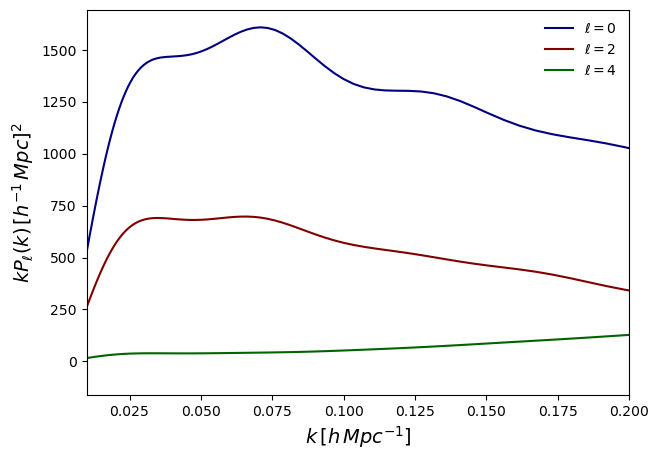

In [27]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(k, k * P0, color = 'navy', ls='-', label=r'$\ell = 0$')
axs.plot(k, k * P2, color = 'maroon', ls='-', label=r'$\ell = 2$')
axs.plot(k, k * P4, color = 'darkgreen', ls='-', label=r'$\ell = 4$')

axs.set_xlim([k[0], 0.2])
#axs.set_ylim([-200.0, 1800])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

In [28]:
############################# Bispectrum ###############################3

In [29]:
classy  = run_class(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.0006442, 
                    As = 2e-9, ns = 0.965, z = 0.3, z_scale=[0.97],
                    N_ur = 2.0328,
                    khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')

In [30]:
#pars for Bispectrum
z_pk=0.0;


b1v = 1;
c1v = 0; b2v = 0.0; bsv = 0;

Omv=classy['cosmo'].Omega0_m();
hv=classy['cosmo'].h(); 
f=classy['cosmo'].scale_independent_growth_factor_f(z_pk)

qparv = 1; qperpv = 1;
Bshotv=0.0
Pshotv=0.0


bisp_nuis_paramsv=[b1v,b2v,bsv,c1v,Bshotv,Pshotv]
bisp_cosmo_paramsv=[Omv, hv, nonlinear.f0]

In [31]:
ks = np.logspace(np.log10(0.0001), np.log10(0.4), 30)
k1k2T = np.vstack([ks,ks]).T

In [32]:
%%time
#precision=[8,10,10]
B000,B202=Bisp_Sugiyama(bisp_cosmo_paramsv, bisp_nuis_paramsv, pk_input=nonlinear.inputpkT, z_pk=z_pk, k1k2pairs=k1k2T, Omfid=-1,qpar=1,qperp=1)#,precision=precision)

1 1
0.6880638639658636
CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 157 ms


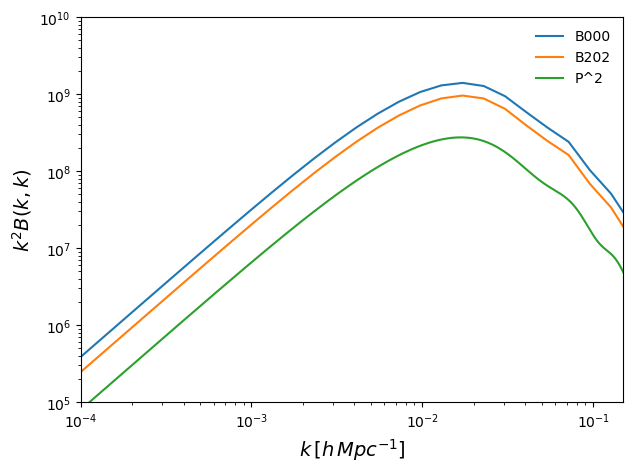

In [33]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) $', fontsize =  14)

#axs.plot(k1k2T.T[0], k1k2T.T[0]*k1k2T.T[0]*B000, ls='-', label='B000')
#axs.plot(k1k2T.T[0],k1k2T.T[0]*k1k2T.T[0]*B202, ls='-', label='B202')


axs.loglog(k1k2T.T[0],B000, ls='-', label='B000')
axs.loglog(k1k2T.T[0],B202, ls='-', label='B202')
axs.loglog(nonlinear.inputpkT[0],nonlinear.inputpkT[1]*nonlinear.inputpkT[1], ls='-', label='P^2')



axs.set_xlim([0.0001,0.15])
axs.set_ylim([1e5, 1e10])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()